# Abstract


# 1. Introduction
Observations have shown that most galaxies in our universe move away from us, with velocities proportional to their distances. The proportionality factor between distance and velocity is called the Hubble constant, or $H$. It is belived to change with time, with the "current" Hubble constant known as $H_0$. In order to determine the Hubble constant, we, in principle, only need the distance and velocity of some distant galaxies. Nearby galaxies gives poor precision, as random movements often dominate the expansion. While finding velocities of distant objects is actually rather achivable, due to the redshift in their EM-spectra, determining distances can be very challenging, and will consume most of our attention. This feat can be accomplished by building a cosmic distance ladder.

### 1.1 The Cosmic Distance Ladder
The cosmic distance ladder is a method for measuring the distance of far away objects, which would be extremely difficult by direct measurement. It is built on the idea of finding different types of stellar objects, which have known distance/property relation for some chosen property. If some of these objects can be observed in the same galaxies, we can approximate their distances to be equal, and "chain" their distance/property relations. This allows us to combine our knowledge of different stellar objects with different advantages, like high visibility far from earth, or very accurately known distances. The ladder also requires the observation of one or more anchors, which are objects with very accuratly known distances, which serves as zero-point refrences.

In theory, this process could be repeated any number of times, by chaining the known relations to any number of object types. We will limit ourselves to three types or objects. We will employ a combination of Cepheids and type Ia supernova, together with the NGC4258 maser as a distance anchor.

### 1.2 Cepheids
Cepheids are very bright, relatively rare, periodically pulsating stars. Like many other pulsating stars (i.e. RR Lyrae), cepheids have predictable period/magnitude relations, making them good standard candles for distance measurements in the tens of Mpc range.

### 1.3 Type Ia Supernova
Type Ia Supernova are some of the brightest objects in the universe, being a result of exploding white dwarfs. They can be observed at extremely large distances, making them great candidates for deriving a distance velocity relation. They are also very rare. 

### 1.4 The NGC 4258 maser
One galaxy of special interest is NGC 4258, which happens to contain a maser, orbiting its central black hole. Maser are strange and very rare celestial objects, which emits large amount of stimulated microwave radiation. This makes them great distance indicators, and the distance to NGC 4258 is therefore known with unparalleled accuracy and precision. It luckily also contains a respectable amount of Cepheids, with both similar and disimiar metallicities from those in the milky way. It therefore provides a great opertunity to calibrate more distant Cepheids, and will serve as the anchor for our distance ladder.


# Notes
WTF3 - Wide Field Camera 3, Hubble Space Telescope (HST).

# 2. Cepheid data extraction and initial analysis
We will employ near-infrared observations of Cepheids from the Wide Field Camera 3 on the Hubble Space Telescope for our analysis of the cepheids. The data has conveniently been catalogued and provided by the Riess team ([Riess et al. 2016](http://adsabs.harvard.edu/abs/2016ApJ...826...56R)) to be downloaded in any desirable format at [this site](http://adsabs.harvard.edu/abs/2016ApJ...826...56R).

We have downloaded a fits file, containing all needed Cepheid data. Below we parse the file to extract inhabiting galaxy, magnitudes, and metallicity.

The set contains a total of 1486 stars in 21 galaxies. One of these galaxies is M31, more commonly known as the Andromeda Galaxy. We are going to have to exclude M31 from our dataset because it happens to be moving towards us. This is a problem, since we are trying to build a predictive model as to how fast stuff is accelerating away from us. There is nothing incompatible between galaxies moving towards us and the expanding universe theory. M31 just happens to be so close to us that random velocities overcomes the general expansion.

Removing M31 leaves us with 1114 stars in 20 galaxies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner
import seaborn as sns
# import mpld3
# mpld3.enable_notebook()
from tqdm import trange
from astropy.io import fits
import pystan
import arviz
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [14.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'Large'
mpl.rcParams['figure.titlesize'] = 'Large'

np.random.seed(1942)

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# 0.RA, 1.DEC, 2.GAL, 3.RA?, 4.DEC?, 5.ID, 6.PERIOD, 7.V-I MAG, 8.F160W mag, 9.sigTOT, 10.O/H, 11.???


with fits.open("asu.fit") as infile:
    data = infile[1].data
    nr_stars = len(data)

    gal = np.empty(nr_stars, dtype=object)  # Galaxy name.
    period = np.zeros(nr_stars)  # Cepheid periods in [Days].
    VImag = np.zeros(nr_stars)  # V-I band magnitude, where V=F555W and I=F814W
    mag = np.zeros(nr_stars)  # H=F160W band magnitude.
    mag_err = np.zeros(nr_stars)  # Standard magnitude error of F160W
    Z = np.zeros(nr_stars)  # Metallicity Z = 12 + Log(O/H)
    for i in trange(nr_stars):
        gal[i] = data[i][2]
        period[i] = data[i][6]
        VImag[i] = data[i][7]
        mag[i] = data[i][8]
        mag_err[i] = data[i][9]
        Z[i] = data[i][10]

100%|██████████| 1486/1486 [00:00<00:00, 3460.62it/s]


In [3]:
print(f"Initial number of stars is {nr_stars}.")
cut_idx = gal != 'M31'
gal = gal[cut_idx]
VImag = VImag[cut_idx]
period = period[cut_idx]
mag = mag[cut_idx]
mag_err = mag_err[cut_idx]
Z = Z[cut_idx]
logP = np.log10(period)
nr_stars = gal.shape[0]
print(f"Removing M31 reduced number of stars to {nr_stars}.")
gal_names = np.unique(gal)
gal_names = np.delete(gal_names, 12)
gal_names = np.append(gal_names, 'N4258')
nr_gals = len(gal_names)
print(f"We are left with {nr_gals} galaxies.")

Initial number of stars is 1486.
Removing M31 reduced number of stars to 1114.
We are left with 20 galaxies.


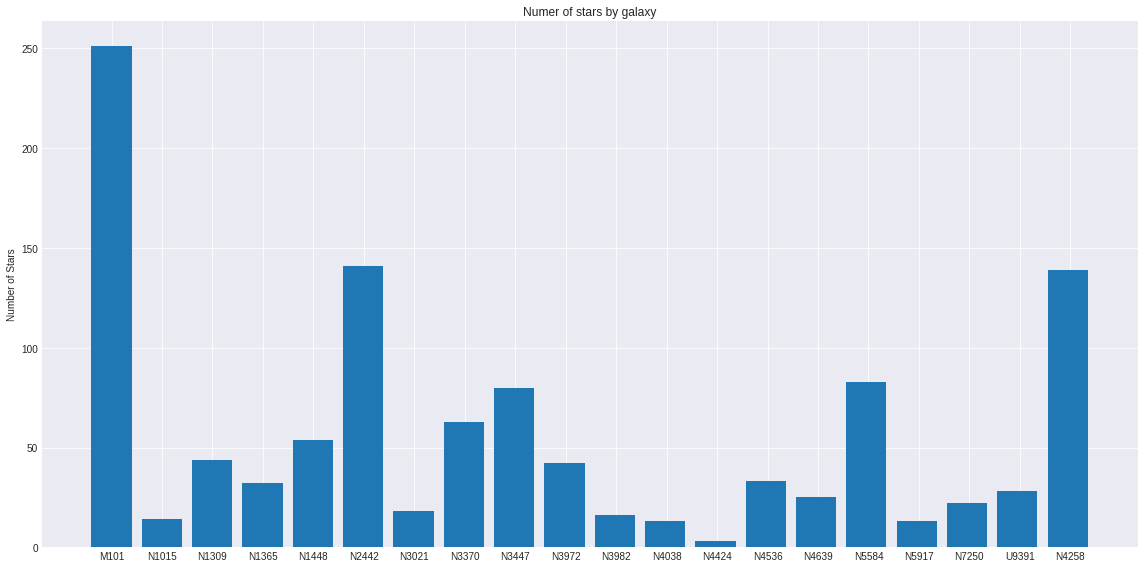

In [13]:
gal_nrs = np.zeros(nr_stars, dtype=int)
for i, gal_name in enumerate(gal_names):
    gal_nrs[gal == gal_name] = i
plt.figure(figsize=(16,8))
plt.hist(gal_nrs, bins=nr_gals, align='left', rwidth=0.8)
plt.xticks(np.linspace(0, nr_gals-1.9, nr_gals), gal_names)
plt.ylabel("Number of Stars")
plt.title("Numer of stars by galaxy")
plt.text
plt.tight_layout();

## 2.1 Wesenheit magnitude
Before we can exploit the period/magnitude relations of the Cepheids, we must adjust the magnitude for extinction. Wesenheit magnitude is a extinction-corrected apperant magnitude, taking into account the dust extinction between us and the object. If we simply used the F160W magnitude, our Cepheids magnitudes would have covariance with extinction, which would severely impact the precision of our model, as it depends on being able to compare magnitude betweens Cepheids, which requires a standardized magnitude. The Wesenheit magnitude is known as 

\\[
    m_W^H=m_H−R\cdot (V−I)\ , \quad\quad R = \frac{A_H}{A_V - A_I}
\\]

Here, $m_H$ is the relative magnitude of the object in the H-band F160W:

\\[
    m_H = M_H + \mu_0,\quad\quad \mu_0 =  5\log(D) + 25
\\]
with $M_H$ as absolute magnitude, and $D$ as distance in Mpc.

Riess et al. 2016 finds $R=0.39$. Below we have calculated the Wesenheit magnitude of all Cepheids.

In [4]:
R = 0.39 # R16, p4.
magW = mag - R*VImag

## 2.2 A look at metallicities

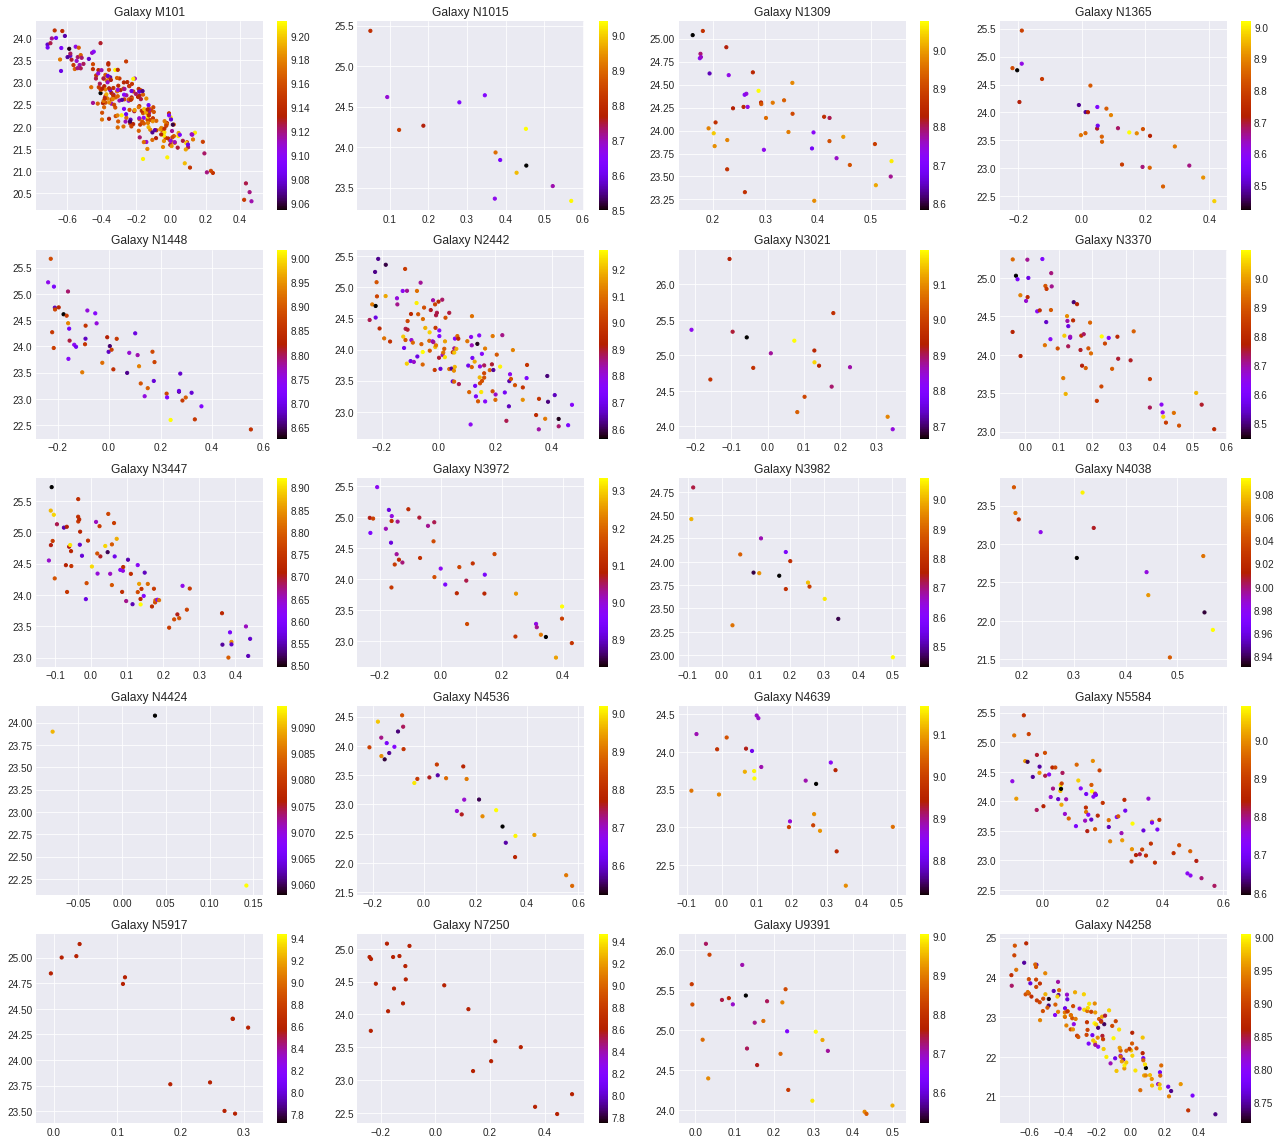

In [51]:
Z_min, Z_max = np.min(Z), np.max(Z)

fig, ax = plt.subplots(5, 4, figsize=(18,16))
for i in range(nr_gals):
    cut_idx = gal == gal_names[i]
    current_magW = magW[cut_idx]
    current_log_period = logP[cut_idx]
    current_Z = Z[cut_idx]
    j, k = i//4, i%4
    sc = ax[j,k].scatter(current_log_period, current_magW, s=10, c=current_Z, cmap="gnuplot")
    ax[j,k].set_title(f"Galaxy {gal_names[i]}")
    plt.colorbar(sc, ax=ax[j,k])
fig.tight_layout()
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(sc, cax=cbar_ax);

# 3. Deriving a magnitude for the Cepheids of NGC 4258 using Stan
## 3.1 The distance to NGC 4258
The Cepheids in NGC 4258 are of special importance, because the distance to their galaxy is known very precisely. Orbiting the central black hole of NGC 4258 is a water maser - the microwave equivalent of a laser, emitting stimulated EM radiation. at 22GHz. The geometric distance to the maser, and therefore the galaxy, can very precisely be determined by direct acceleration measurements, and fitting its Keplerian motion around the black hole. [Humphreys et al. 2013](https://arxiv.org/abs/1307.6031) explains this process in detail, and derives a 3% certainty of the geometric distance. The best distance estimate to NGC 4258 we could find was however presented in [Riess et al. 2016](https://arxiv.org/abs/1604.01424), which claims to have reduced the error to 2.6% by running the MCMC model proposed by Humpreys et al. 2013 for longer. They present the distance modulus of $\mu_\mathrm{0,N4258} = 29.387 \pm 0.0568$, corresponding to a distance of $7.54\, \mathrm{Mpc}$.

Masers are very rare, and NGC 4258 is the only galaxy in our model on which we can employ this approach. It will therefore serve as a distance anchor for the rest of our model.

## 3.2 Building a magnitude model
The Cepheids are expected to have predictable relations between their period and standardized (Wesenheit) magnitude. We will also throw in a magnitude depedence on metallicity, to improve our model. The dependence on both these parameters are assumed to be power laws, meaning we will get a nice, linear fit if we use the logarithms of the parameters in our model. The model will then consist of the slope coefficients of both parameters, as well as a intercept. The model then becomes

\\[
    m_{H}^{W}=\mathrm{zp}_\mathrm{W,N4258} + b_{W} \Delta\log P+Z_{W} \Delta \log (\mathrm{O} / \mathrm{H})
\\]

where $\mathrm{zp}_\mathrm{W,N4258}$, $b_{W}$, and $Z_{W}$ are fitting parameters. We have also scaled the metallicity relative to that of our own sun, at $\log(\mathrm{O} / \mathrm{H})_{\mathrm{sun}} = 8.66$, such that

\\[
    \Delta \log (\mathrm{O} / \mathrm{H}) = \log (\mathrm{O} / \mathrm{H}) - \log(\mathrm{O} / \mathrm{H})_{\mathrm{sun}}
\\]

The log period is also scaled by the mean of all log period, such that

\\[
    \Delta \log P = \log P - \overline{\log P}
\\]

Scaling parameters to values around their mean should have no effect on our final best fit, but helps reduce covariance between parameters.

## 3.3 Fitting the model with Stan
### 3.3.1 The HMC No-U-Turn-Sampler
STAN is a statistical programming language, used for Monte Carlo simulations of hierarchical models. It has a Python module called PyStan, which compiles to C++, and is generally more efficient than most MCMC options. It comes equiped with a powerful class of Hamiltonian Monte Carlo (HMC) samplers, which often holds strong advantages to more traditional sampling models. For complex, many-dimensional probability surfaces, where traditional sampling methods struggle with convergence, HMC shines. It comes at the cost of more calculations per cycle, and involves calculating the gradient of the probability surface, the difficulty of which depends on the problem, and ranges from trivial, to hugely expensive. However, when dealing with the number of dimensions we shall (>20), it will perform admirably.

HMC is built on the concept of considering the probability surface to be a physical potential, and exploring the surface in the way a frictionless object would roll around it. It calculates the hamiltonian of the system (from where it gets its name), and solves a series of path integrals, using leap-frog integration, in order to explore the probability surface. Here, we will employ a popular HMC variant called the No-U-Turn-Sampler. It is a special adaption of HMC which attempts to explore the surface as efficiently as possible, by attempting to avoid exploring the same path over and over ("no u-turns"), and instead starting the sampling from a different initial conditions if it finds the sampler to be re-exploring the same path.

In [6]:
logP = logP - np.mean(logP)

In [7]:
Z_ref = 8.66
dOH = Z - Z_ref

N4258_cut_idx = gal == "N4258"
dOH_N4258 = dOH[N4258_cut_idx]
magW_N4258 = magW[N4258_cut_idx]
logP_N4258 = logP[N4258_cut_idx]
mag_err_N4258 = mag_err[N4258_cut_idx]

### 3.3.2 Implementation
We will be fitting the magnitude-relation equation with maximum likelihood estimation in Stan, assuming gaussian errors on the magnitude. We will also be including an intrinsic scatter, which will give us more information about how extensive our model is.

Below, the Stan code is shown and compiled. The Stan code is divided in 4 sections - data, paramters, transformed parameters, and model. The data section contains declarations of all data to be provided, while the paramters section does the same for all fitting paramters Stan should create. The transformed parameters sections allows calculation of new parameters to be used in the model, where we calculate the right-hand side of the above fitting equation, as well as the left-hand side standard error, including scatter. The model section contains the posterior, where we have put the priors on the fitting parameters, as well as the likelihood of the magnitude function.

We have used uninformed priors for all four parameters, set at reasonable ranges after some initial testing.

The model is run with 20000 samples for each of 8 parallell chains. The first half of them are discarded, as they any MC sampler is initially influenced by its initial conditions (which has been set random within the uniform priors). We also thin the final samples, keeping only every xth sample, so to not completely overload our plotting modules.

In [60]:
# set prior characteristics 
stan_dict = {}
stan_dict['zp_lower'], stan_dict['zp_upper'] = 23.0-5, 30.0-5
stan_dict['bW_lower'], stan_dict['bW_upper'] = -5.0, 0.0
stan_dict['ZW_lower'], stan_dict['ZW_upper'] = -4.0, 4.0
stan_dict['s_lower'], stan_dict['s_upper'] = 0.0, 2.0


stan_code = """
data {{
// define the data within Stan
int<lower=0> N;           // number of data points    
real magW[N];                // x values             
real logP[N];               // y values            
real dOH[N];
real<lower=0> sigma_magW[N];  // y error bars
}}
parameters {{
// model parameters
real<lower={zp_lower}, upper={zp_upper}> zp;
real<lower={bW_lower}, upper={bW_upper}> bW;
real<lower={ZW_lower}, upper={ZW_upper}> ZW;
real<lower={s_lower},  upper={s_upper}>  s;
}}
transformed parameters{{
// construct the model (i.e., theta=mx+b)
real theta[N];
real tot_sigma[N];
for (j in 1:N)
theta[j] = zp + bW * logP[j] + ZW * dOH[j];
for (j in 1:N)
tot_sigma[j] = sqrt(square(sigma_magW[j]) + square(s));
}}
model {{
zp ~ uniform({zp_lower}, {zp_upper});     //a slope has a normal distribution 
bW ~ uniform({bW_lower}, {bW_upper});   // y-intercept has a uniform distribution
ZW ~ uniform({ZW_lower}, {ZW_upper});
s ~ uniform({s_lower}, {s_upper});
magW ~ normal(theta, tot_sigma);            // data points have a normal distribution -> Gaussian likelihood function
}}
"""

# create the model
sm = pystan.StanModel(model_code=stan_code.format(**stan_dict))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1db22b0b5cf4381f8fb95a6e48c47b05 NOW.


In [61]:
# set the data
linear_data = {'N': len(logP_N4258),
               'magW': magW_N4258,
               'logP': logP_N4258,
               'dOH' : dOH_N4258,
               'sigma_magW': mag_err_N4258}


Nsamples = 25000 # number of samples
warmup = 5000 # number of burn in samples (stan default is half of Nsamples)
chains = 8 # number of chains
thin = 10 # discard every n=thin samples in the end 
seed = 128 # random seed for starting the chain


# run the model
fit = sm.sampling(data=linear_data, iter=Nsamples, chains=chains, warmup=warmup, thin=thin, seed=seed, init='random')#, control={'adapt_delta' : 2})
samples = fit.extract(permuted=True)  # Extracting Sample Data
stackedsamples = np.vstack((samples['zp'], samples['bW'], samples['ZW'], samples['s'])).T  # pull out parameters of interest and reshape them

## 3.4 Results
Below, a printout of the mean values, together with error diviations in each direction, and signal to noise ratio (SNR) is provided. The intercept has very high SNR, which is good, as it is the only of the paramters we actually care about. The period slope has a pretty standard SNR, while the metallicity slope lies very low. This is expected, as the period dependence is very evident, while the metallicity is much less so. As a matter of fact, we can't even tell if the slope is positive or negative within one sigma.

From the corner plots shown below, we see nice gaussian-like behaviour on all parameter samples. There is almost no covariance, with the exception of the intercept and the metallicity slope.

WRONG. WHATSUP?
This was the covariance we were trying to get rid of by rescaling the , but NGC 4258 happens to have Cepheids with much lower than average periods, reintroducing the covariance in this particular galaxy.

zp =  22.0113 (+0.0800, -0.0769)  --  SNR = 280.68
bW =  -3.1532 (+0.1115, -0.1125)  --  SNR = 28.15
ZW =   0.1137 (+0.3545, -0.3642)  --  SNR = 0.32
 s =   0.1385 (+0.0430, -0.0493)  --  SNR = 3.00


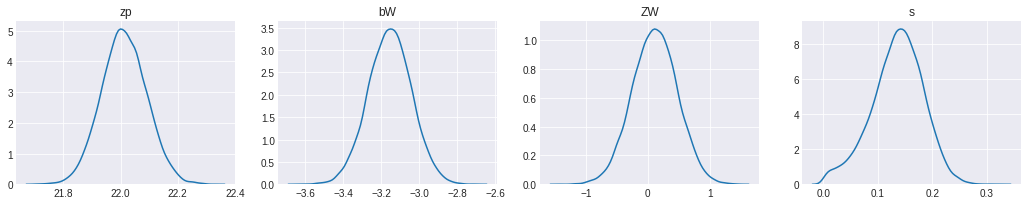

In [71]:
zp, bW, ZW, s = np.percentile(stackedsamples, [16, 50, 84], axis=0).T
zp_N4258, zp_N4258_sigma = zp[1], (zp[2]-zp[0])/2

print(f"zp = {zp[1]:8.4f} (+{zp[2]-zp[1]:6.4f}, -{zp[1]-zp[0]:6.4f})  --  SNR = {zp[1]*2/(zp[2]-zp[0]):.2f}")
print(f"bW = {bW[1]:8.4f} (+{bW[2]-bW[1]:6.4f}, -{bW[1]-bW[0]:6.4f})  --  SNR = {abs(bW[1])*2/(bW[2]-bW[0]):.2f}")
print(f"ZW = {ZW[1]:8.4f} (+{ZW[2]-ZW[1]:6.4f}, -{ZW[1]-ZW[0]:6.4f})  --  SNR = {ZW[1]*2/(ZW[2]-ZW[0]):.2f}")
print(f" s = {s[1]:8.4f} (+{s[2]-s[1]:6.4f}, -{s[1]-s[0]:6.4f})  --  SNR = {s[1]*2/(s[2]-s[0]):.2f}")

fig, ax = plt.subplots(1, 4, figsize=(18,3))
names_list = ['zp', 'bW', 'ZW', 's']
for i, name in enumerate(names_list):
    sns.distplot(samples[name], hist=False, ax=ax[i])
    ax[i].set_title(name)

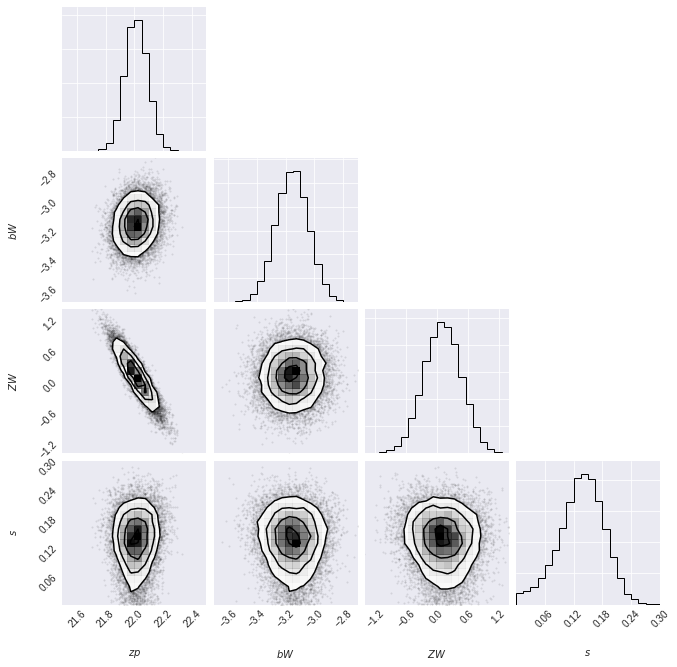

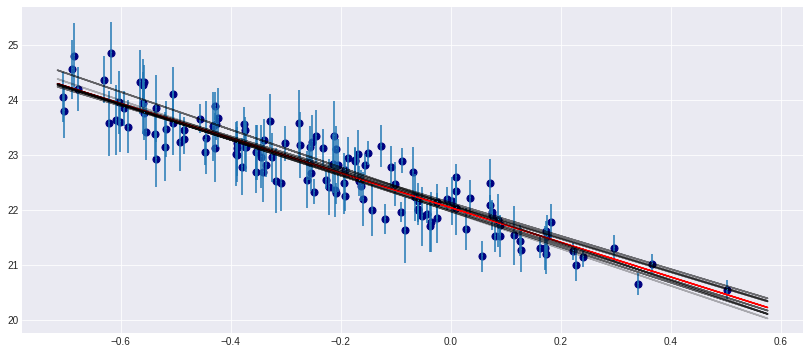

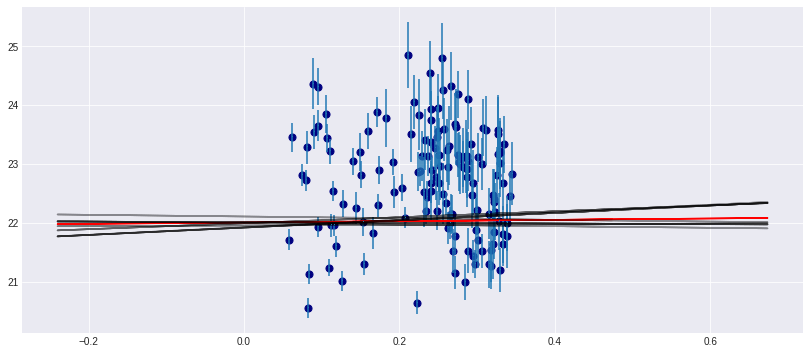

In [94]:
postsamples = np.vstack((samples['zp'], samples['bW'], samples['ZW'], samples['s'])).T
fig = corner.corner(postsamples, labels=[r"$zp$", r"$bW$", r"$ZW$", r"$s$"], range=[(21.5,22.5), (-3.7,-2.7), (-1.4, 1.4), (0, 0.3)])

plt.figure(figsize=(14,6))
plt.errorbar(logP_N4258, magW_N4258, yerr=mag_err_N4258, fmt=",")
sc = plt.scatter(logP_N4258, magW_N4258, s=50, c="navy")
plt.plot(logP, zp[1] + bW[1]*logP + ZW[1]*np.mean(dOH), c="r")

for i in np.random.randint(len(samples), size=50):
    plt.plot(logP, samples['zp'][i] + samples['bW'][i]*logP + samples['ZW'][i]*np.mean(dOH), c="k", alpha=0.1)
# plt.plot(logP, zp[0] + bW[0]*logP + ZW[1]*np.mean(dOH), ls="--", c="y")
# plt.plot(logP, zp[2] + bW[2]*logP + ZW[1]*np.mean(dOH), ls="--", c="y");

plt.figure(figsize=(14,6))
plt.errorbar(dOH_N4258, magW_N4258, yerr=mag_err_N4258, fmt=",")
sc = plt.scatter(dOH_N4258, magW_N4258, s=50, c="navy")
plt.plot(dOH, (zp[1]) + bW[1]*np.mean(logP) + ZW[1]*dOH, c="r")

# plt.plot(dOH, zp[0] + bW[0]*np.mean(logP) + ZW[0]*dOH, ls="--", c="y")
# plt.plot(dOH, zp[2] + bW[2]*np.mean(logP) + ZW[2]*dOH, ls="--", c="y");
for i in np.random.randint(len(samples), size=50):
    plt.plot(dOH, samples['zp'][i] + samples['bW'][i]*np.mean(logP) + samples['ZW'][i]*dOH, c="k", alpha=0.1)

# 4. Extending the model to all galaxies
## 4.1 Model Introduction
Consider the magnitude model employed in the previous section, and imagine it employed to Cepheids in a different galaxy, with some distance modulus $\mu_{0,i}$. We wish to take advantage of our very accurate knowledge of the distance to our anchor, NGC 4258, as well as our estimate that all Cepheids follows the same magnitude model. We therefore employ the equation used in the previous section, this time with the intercept $zp_{W,N4258}$ fixed at the derived value. Since this intercept is fitted for NGC 4258 specifically, we introduce a distance modulus difference, $\Delta \mu_{0,i} = \mu_{0,i} - \mu_{0,N4258}$, which accounts for the magnitude difference resulting from the varying distances to the galaxies. It can be thought of as moving all the Cepheids into NGC 4258, to make them follow the same trend. The reason this works is because the distance modulus is defined to be exactly the magnitude difference induced by changing the distance to an object: $\Delta m = \Delta \mu$.

\\[
    m_{H,i,j}^W = \underbrace{(\mu_{0,i} - \mu_{0,N4258})}_{\Delta \mu_{0,i}} + zp_{W,N4258} + b_W \log{P_{i,j}} + Z_W\Delta\log{(O/H)_{i,j}}
\\]

Techinally, the intercept will not be fixed, but will be subject to a gaussian likelihood function with the mean and standard error found in the last section. This will not change best-fit results, but allow for proper error propagation from the intercept into the other derived values.

## 4.2 Implementation
The code implementation is similar to before, employing uniform priors on all parameters. One large difference is the addition of 19 new parameters, namely the distance modulus differences to NGC 4258 for all galaxies. These will all need to be fitted seperately. As can be noted above, there is now also two indexes to account for - both the number of stars and the number of galaxies. The slopes are shared between all stars, while the distance modulus is only shared between stars in the same galaxy, making for a somewhat odd set of equations.

We still run with Stan's No-U-Turn sampler, employing 8 chains, x iterations, and so on. Intrinsic scatter is also included.

In [14]:
cut_idx_galaxies = gal_names != 'N4258'
cut_idx_stars = gal_nrs != 19
magW2 = magW[cut_idx_stars]
mag_err2 = mag_err[cut_idx_stars]
logP2 = logP[cut_idx_stars]
dOH2 = dOH[cut_idx_stars]
gal_nrs2 = gal_nrs[cut_idx_stars]

nr_stars2 = magW2.shape[0]
nr_gals2 = nr_gals-1

dOH2.shape, logP2.shape, magW2.shape, gal_nrs2.shape, nr_gals2

((975,), (975,), (975,), (975,), 19)

In [15]:
# set prior characteristics 
stan_dict2 = {}
stan_dict2['dmu_lower'], stan_dict2['dmu_upper'] = -5, 30.0
stan_dict2['bW_lower'], stan_dict2['bW_upper'] = -5.0, 0.0
stan_dict2['ZW_lower'], stan_dict2['ZW_upper'] = -5.0, 5.0
stan_dict2['s_lower'], stan_dict2['s_upper'] = 0.0, 2.0
stan_dict2['zp_N4258_mean'], stan_dict2['zp_N4258_sigma'] = zp_N4258, zp_N4258_sigma

# create the model
stan_code2 = """
data {{
// define the data within Stan
int<lower=0> N;           // number of data points    
int<lower=0> n;     // number of galaxies
int gal_nrs[N];
real magW[N];
real logP[N];            
real dOH[N];
real<lower=0> sigma_magW[N];
real zp_N4258_mean;
real zp_N4258_sigma;
}}
parameters {{
// model parameters
real<lower={dmu_lower}, upper={dmu_upper}> dmu[n];
real<lower={bW_lower}, upper={bW_upper}> bW;
real<lower={ZW_lower}, upper={ZW_upper}> ZW;
real<lower={s_lower}, upper={s_upper}> s;
real<lower=zp_N4258_mean-2*zp_N4258_sigma, upper=zp_N4258_mean+2*zp_N4258_sigma> zp_N4258;
}}
transformed parameters{{
// construct the model
real theta[N];
real tot_sigma[N];
for (j in 1:N)
theta[j] = dmu[gal_nrs[j]] + zp_N4258 + bW * logP[j] + ZW * dOH[j];
for (j in 1:N)
tot_sigma[j] = sqrt(square(sigma_magW[j]) + square(s));
}}
model {{
for (j in 1:n)
dmu[j] ~ uniform({dmu_lower}, {dmu_upper});
bW ~ uniform({bW_lower}, {bW_upper});
ZW ~ uniform({ZW_lower}, {ZW_upper});
s ~ uniform({s_lower}, {s_upper});
magW ~ normal(theta, tot_sigma);
zp_N4258 ~ normal(zp_N4258_mean, zp_N4258_sigma);
}}
"""
sm2 = pystan.StanModel(model_code=stan_code2.format(**stan_dict2))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b264bfb525f623d5337cb889a7c5b98 NOW.


In [16]:
Nsamples = 10000 # number of samples
warmup = 5000 # number of burn in samples (stan default is half of Nsamples)
chains = 8 # number of chains
thin = 4 # discard every n=thin samples in the end 
seed = 128 # random seed for starting the chain

# set the data
linear_data2 = {'N': nr_stars2,
               'n' : nr_gals2,
               'gal_nrs' : gal_nrs2+1,  # Stan indexes from 1.
               'magW': magW2,
               'logP': logP2,
               'dOH' : dOH2,
               'sigma_magW': mag_err2,
               'zp_N4258_mean' : zp_N4258,
               'zp_N4258_sigma' : zp_N4258_sigma}

# run the model
fit2 = sm2.sampling(data=linear_data2, iter=Nsamples, chains=chains, warmup=warmup, thin=thin, seed=seed)#, control={'adapt_delta' : 0.99})
samples2 = fit2.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [17]:
pystan.check_hmc_diagnostics(fit2)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

## 4.3 Results
Below we see that the slopes have massively increased in SNR, with a slight bump to the intercept as well (which was allowed to move slightly around its mean from last run).

The massive corner plot below shows nice gaussian-looking samples on all parameters, and low covariance on almost all values.

In [18]:
dmu2 = np.percentile(samples2['dmu'], [16,50,84], axis=0)
zp2 = np.percentile(samples2['zp_N4258'], [16,50,84])
bW2 = np.percentile(samples2['bW'], [16,50,84])
ZW2 = np.percentile(samples2['ZW'], [16,50,84])
s2 = np.percentile(samples2['s'], [16,50,84])

print(f"zp = {zp2[1]:8.4f} (+{zp2[2]-zp2[1]:6.4f}, -{zp2[1]-zp2[0]:6.4f})  --  SNR={zp2[1]*2/(zp2[2]-zp2[0]):.2f}")
print(f"bW = {bW2[1]:8.4f} (+{bW2[2]-bW2[1]:6.4f}, -{bW2[1]-bW2[0]:6.4f})  --  SNR={abs(bW2[1])*2/(bW2[2]-bW2[0]):.2f}")
print(f"ZW = {ZW2[1]:8.4f} (+{ZW2[2]-ZW2[1]:6.4f}, -{ZW2[1]-ZW2[0]:6.4f})  --  SNR={abs(ZW2[1])*2/(ZW2[2]-ZW2[0]):.2f}")
print(f" s = {s2[1]:8.4f} (+{s2[2]-s2[1]:6.4f}, -{s2[1]-s2[0]:6.4f})  --  SNR={s2[1]*2/(s2[2]-s2[0]):.2f}")

zp =  22.0109 (+0.0724, -0.0715)  --  SNR=305.90
bW =  -3.0334 (+0.0549, -0.0528)  --  SNR=56.33
ZW =  -0.2317 (+0.0921, -0.0930)  --  SNR=2.50
 s =   0.1233 (+0.0157, -0.0160)  --  SNR=7.78


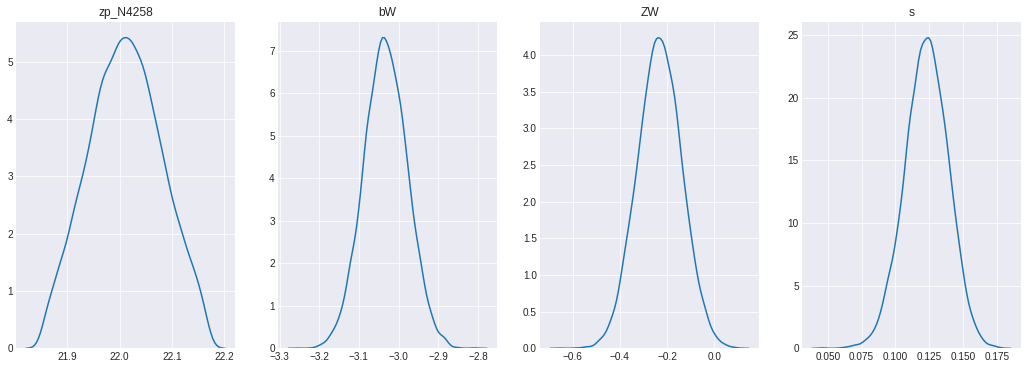

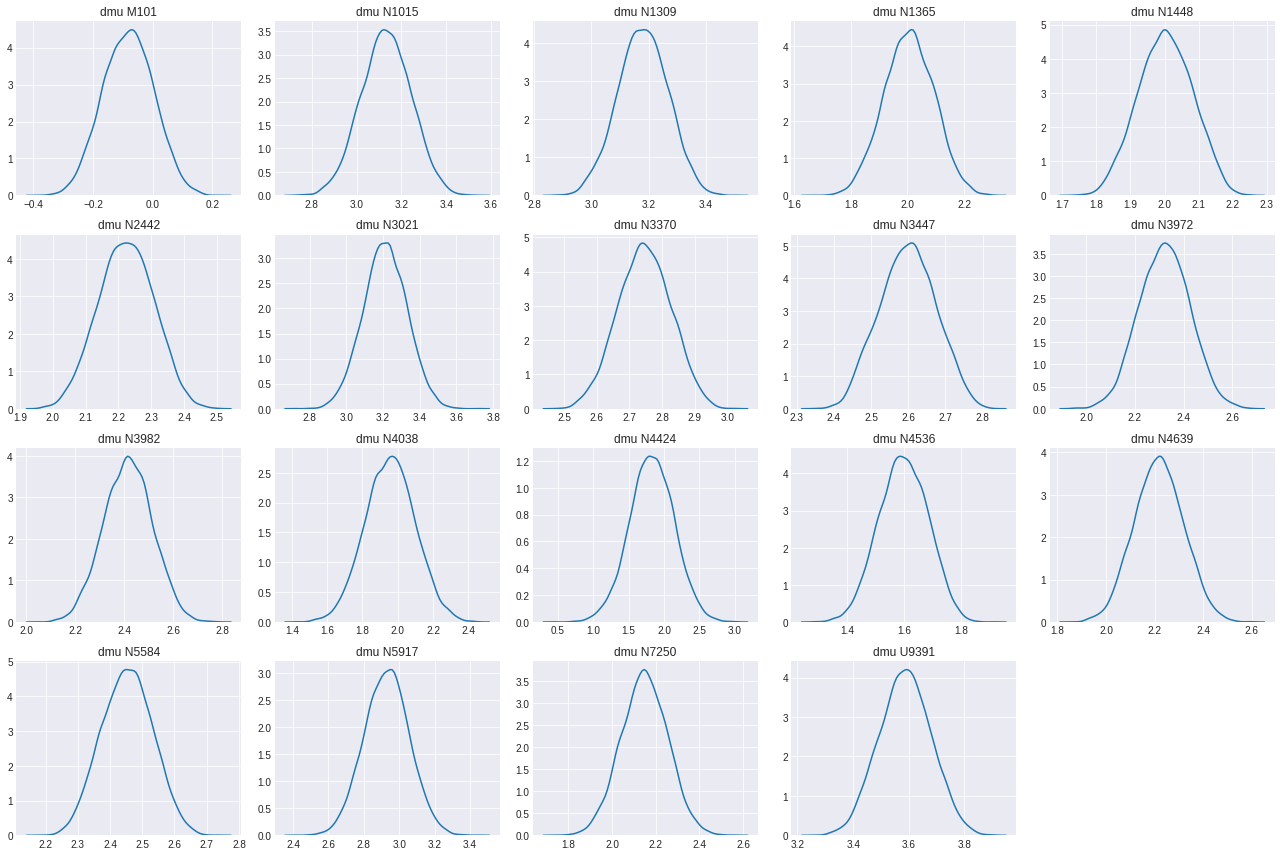

In [19]:
samples_data2 = fit2.extract()
fig, ax = plt.subplots(1, 4, figsize=(18,6))
names_list = ['zp_N4258', 'bW', 'ZW', 's']
for i, name in enumerate(names_list):
    sns.distplot(samples_data2[name], hist=False, ax=ax[i])
    ax[i].set_title(name)
    
fig, ax = plt.subplots(4, 5, figsize=(18,12))
for i in range(19):
    sns.distplot(samples_data2['dmu'][:,i], hist=False, ax=ax[i//5, i%5])
    ax[i//5, i%5].set_title('dmu ' + gal_names[i])
ax[-1,-1].axis('off');
plt.tight_layout()

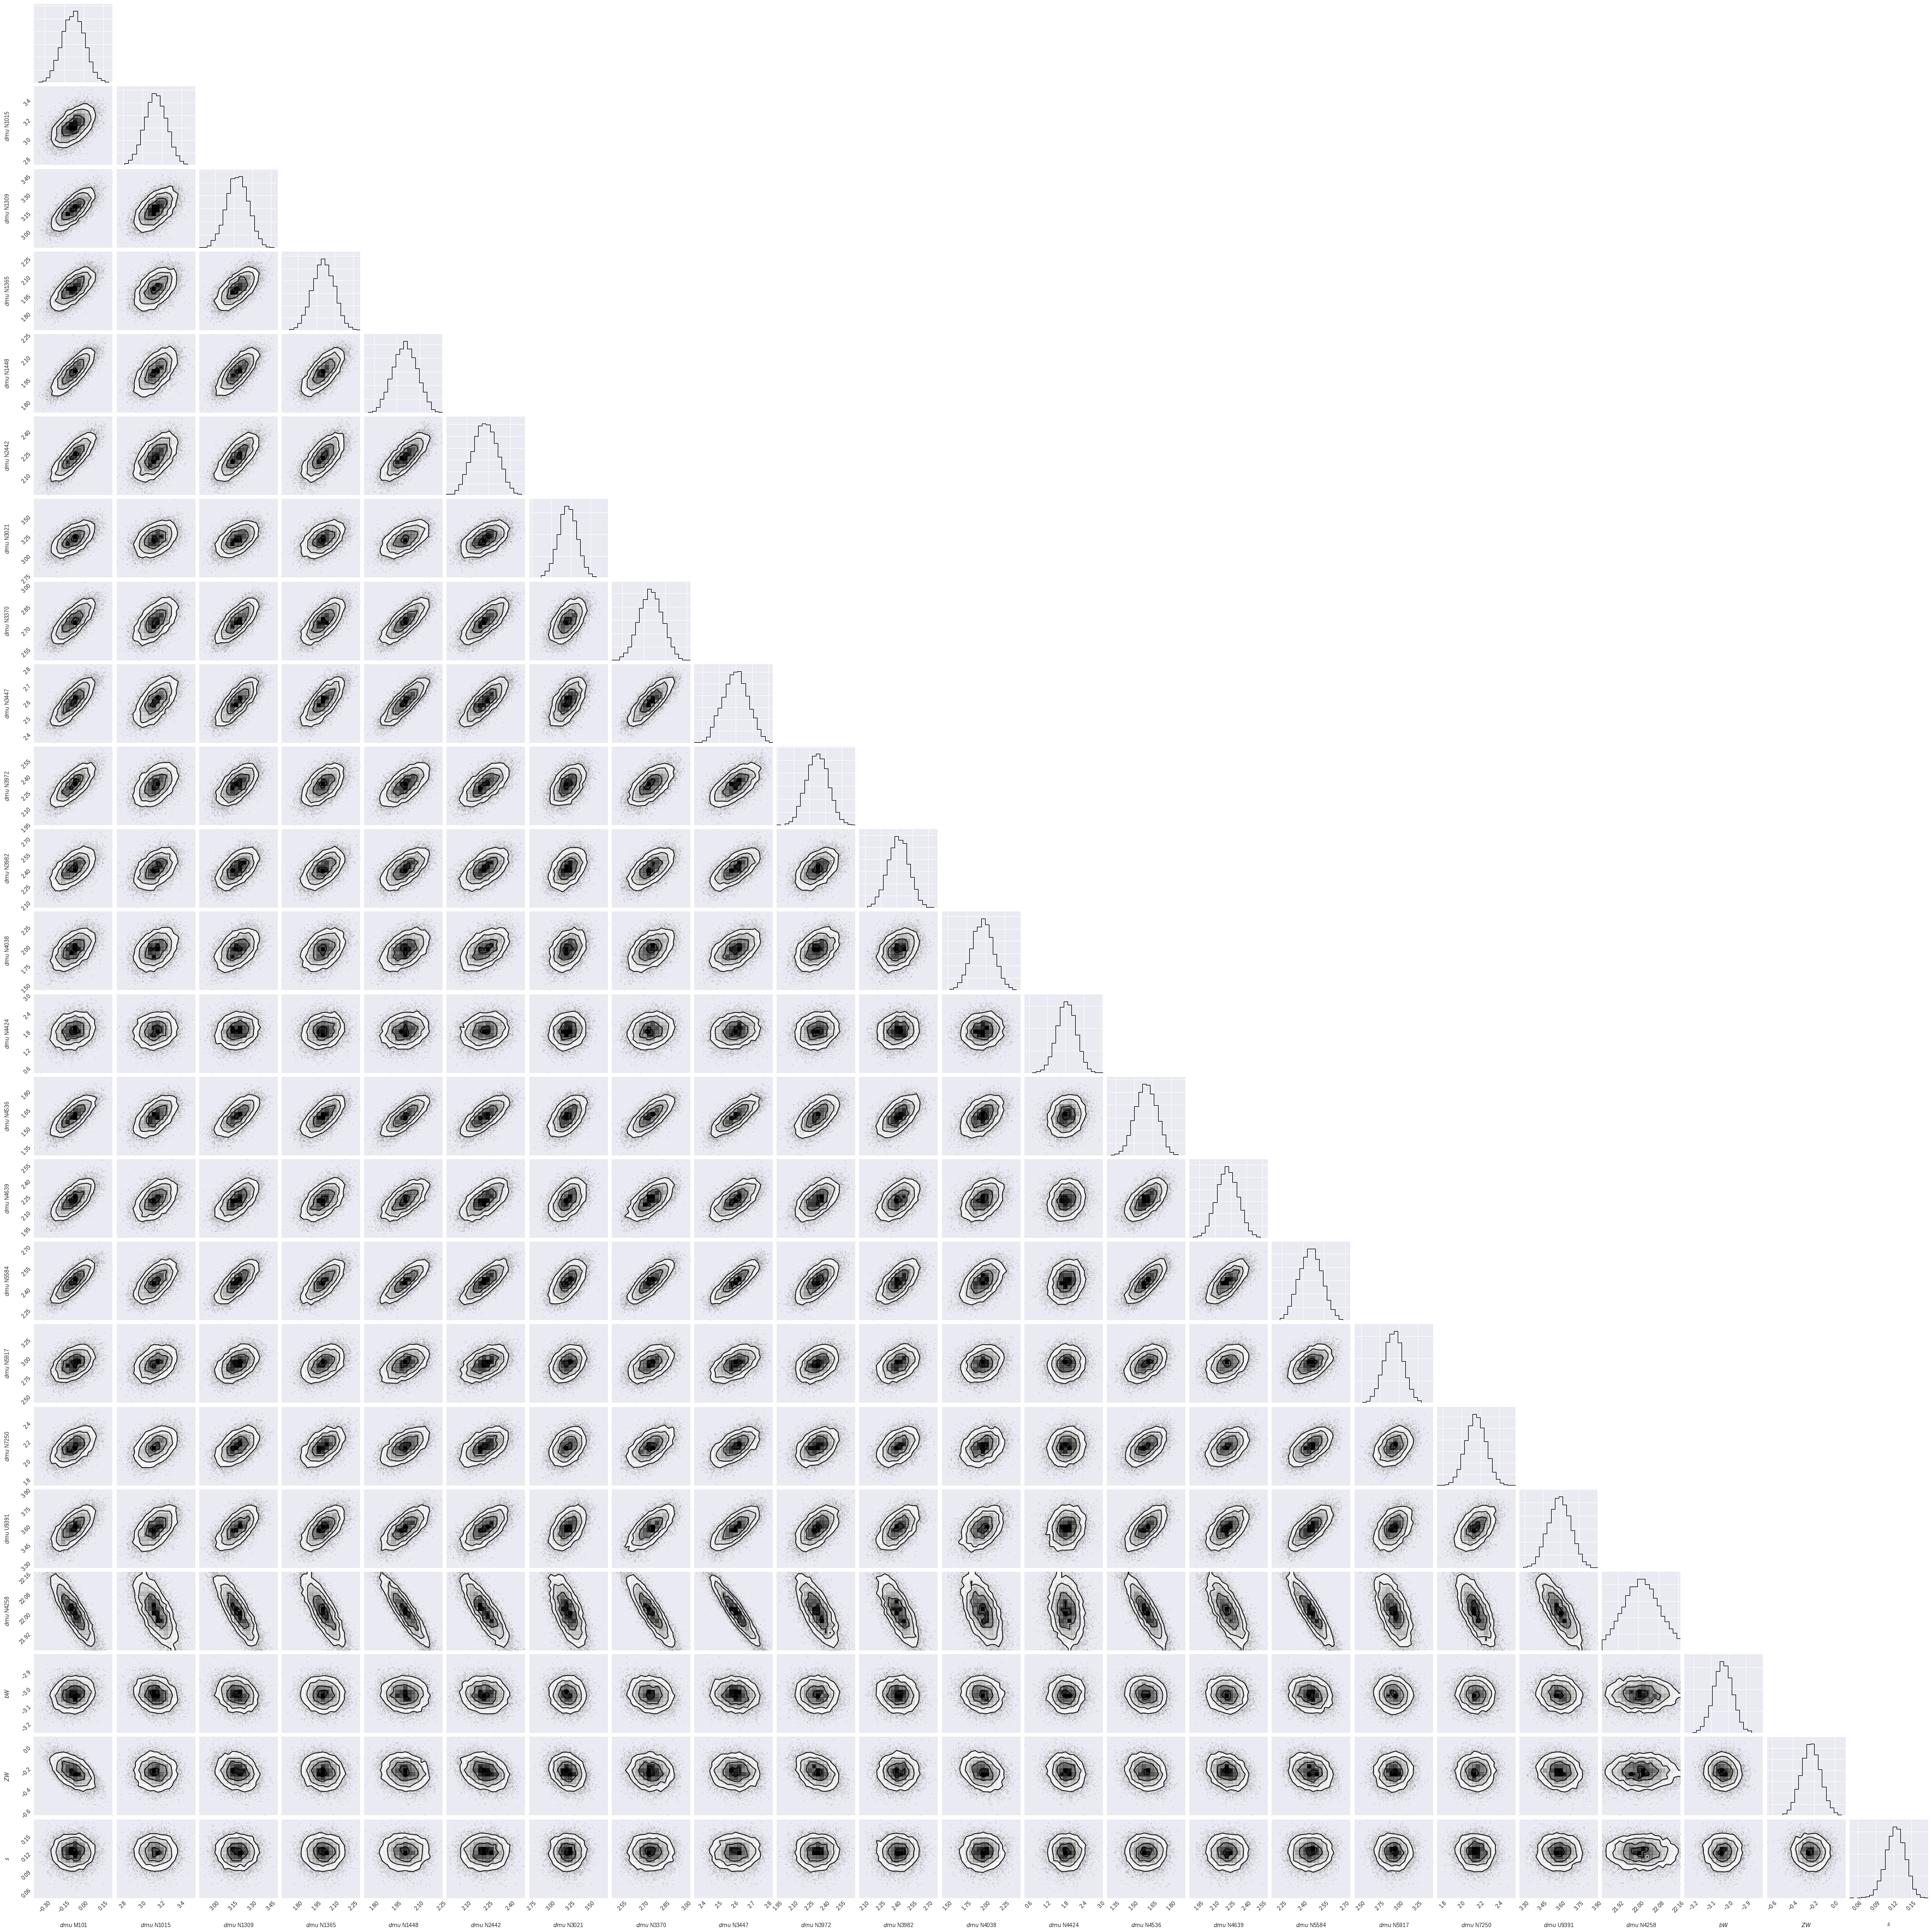

In [20]:
samples2 = fit2.extract(permuted=True)   # fit contains all information on chains
stackedsamples2 = np.vstack((*samples2['dmu'].T, samples2['zp_N4258'], samples2['bW'], samples2['ZW'], samples2['s'])).T  # pull out parameters of interest and reshape them
fig = corner.corner(stackedsamples2, labels=[*[r"$dmu$ "+str(gal) for gal in gal_names], r"$bW$", r"$ZW$", r"$s$"])  # let's make a corner plot

### 4.3.1 Comparison to previous covariances
Overplotting the new samples from only NGC 4258 on the corner plot from the previous run, we see that the uncertainty in all parameters (except the slope, zp) is vastly reduced. The new values also lies comfortably within the previous estimates, which is a good sign. It is also very interesting to note how the covariance between metallicity slope and intercept is entirely gone.

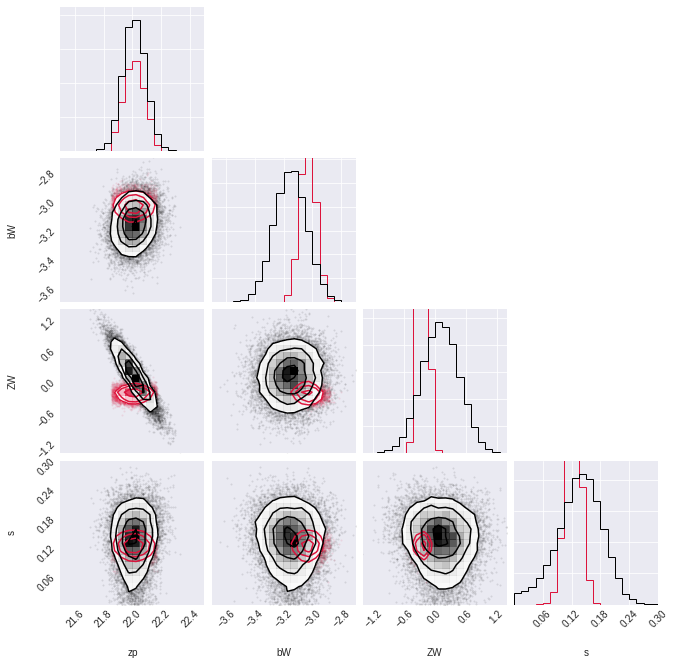

In [45]:
fig = corner.corner(stackedsamples2[:,19:], color="crimson", labels=['zp', 'bW', 'ZW', 's'],  range=[(21.5,22.5), (-3.7,-2.7), (-1.4, 1.4), (0, 0.3)])
corner.corner(stackedsamples, fig=fig, labels=['zp', 'bW', 'ZW', 's'], range=[(21.5,22.5), (-3.7,-2.7), (-1.4, 1.4), (0, 0.3)]);

\\[
    m_{H,i,j}^W = \underbrace{(\mu_{0,i} - \mu_{0,N4258})}_{dmu} + zp_{W,N4258} + b_W \log{P_{i,j}} + Z_W\Delta\log{(O/H)_{i,j}}
\\]

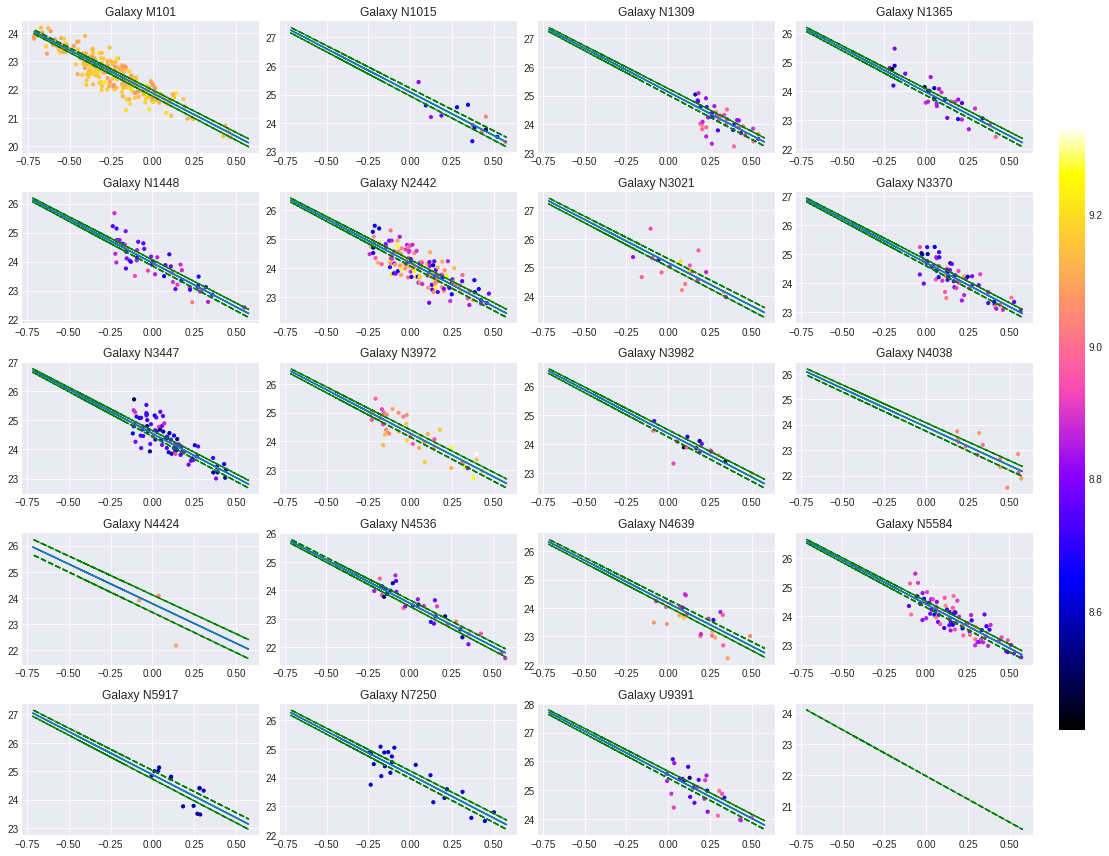

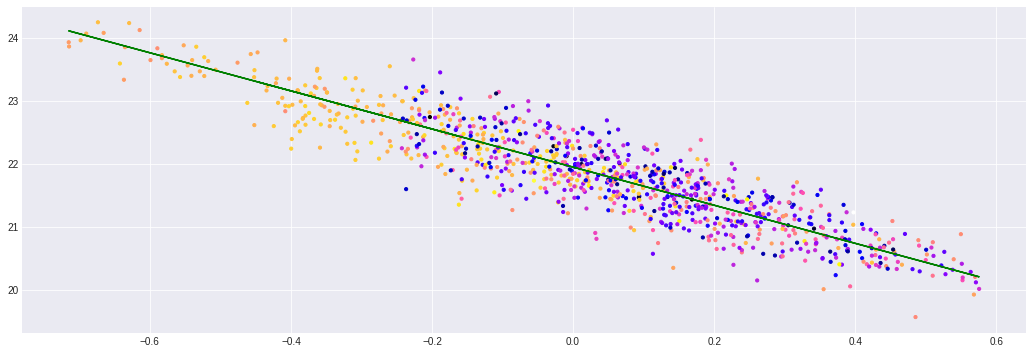

In [53]:
fig, ax = plt.subplots(5, 4, figsize=(18,12))
fig2, ax2 = plt.subplots(1, figsize=(18,6))
for i in range(nr_gals2):
    cut_idx = gal == gal_names[i]
    current_magW = magW[cut_idx]
    current_logP = logP[cut_idx]
    current_dOH = Z[cut_idx]
    j, k = i//4, i%4
    ax[j,k].set_title(f"Galaxy {gal_names[i]}")
    sc = ax[j,k].scatter(current_logP, current_magW, s=10, c=current_dOH, cmap="gnuplot2", vmin=Z_min, vmax=Z_max)
    ax2.scatter(current_logP, current_magW - dmu2[1,i], s=10, c=current_dOH, cmap="gnuplot2", vmin=Z_min, vmax=Z_max)

    ax[j,k].plot(logP, dmu2[1,i] + zp_N4258 + bW2[1]*logP + ZW2[1]*np.mean(dOH))
    
    ax[j,k].plot(logP, dmu2[0,i] + zp_N4258 + bW2[0]*logP + ZW2[0]*np.mean(dOH), ls="--", c="g")
    ax[j,k].plot(logP, dmu2[2,i] + zp_N4258 + bW2[2]*logP + ZW2[2]*np.mean(dOH), ls="--", c="g")

ax2.plot(logP, zp_N4258 + bW2[1]*logP + ZW2[1]*np.mean(dOH), c="g")
ax[-1,-1].plot(logP, zp_N4258 + bW2[2]*logP + ZW2[2]*np.mean(dOH), ls="--", c="g")
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax);

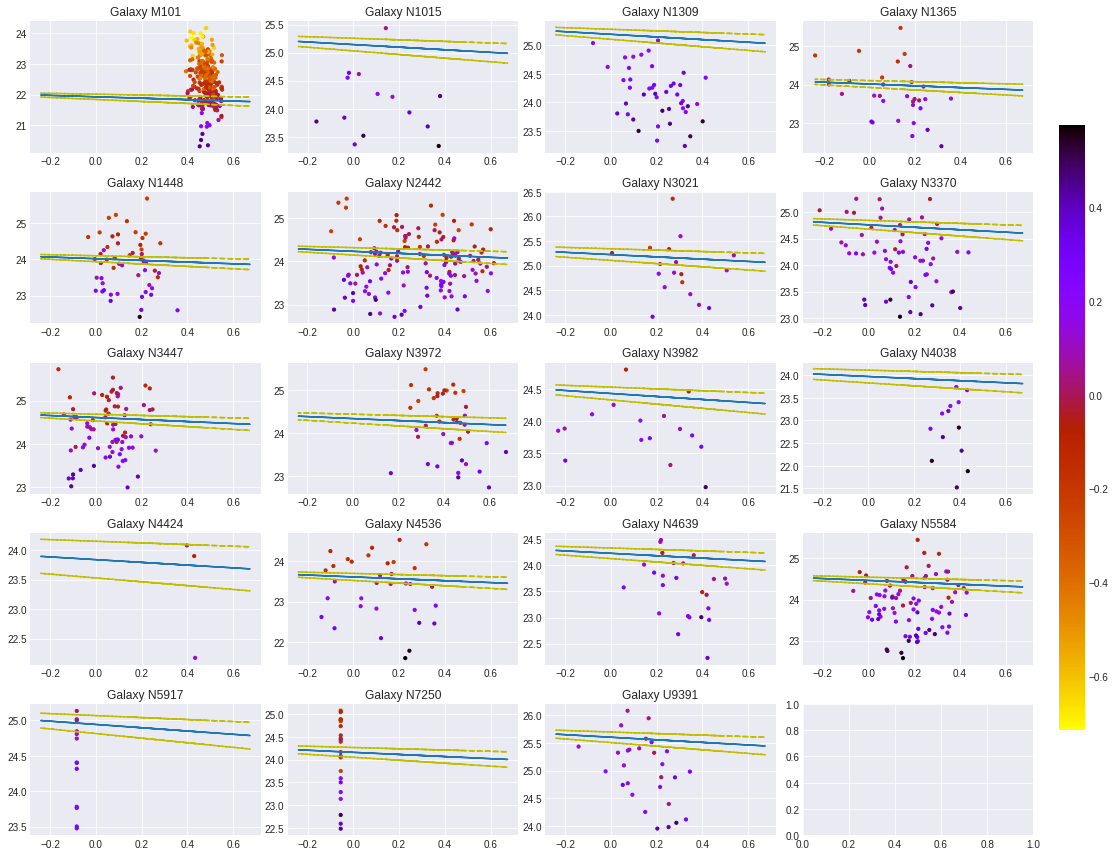

In [56]:
logP_min, logP_max = np.min(logP), np.max(logP)
fig, ax = plt.subplots(5, 4, figsize=(18,12))
for i in range(nr_gals2):
    cut_idx = gal == gal_names[i]
    current_magW = magW[cut_idx]
    current_log_period = logP[cut_idx]
    current_Z = Z[cut_idx]
    j, k = i//4, i%4
    sc = ax[j,k].scatter(current_Z-Z_ref, current_magW, s=10, c=current_log_period, cmap="gnuplot_r", vmin=logP_min, vmax=logP_max)
    ax[j,k].set_title(f"Galaxy {gal_names[i]}")
    ax[j,k].plot(dOH, dmu2[1,i] + zp_N4258 + bW2[1]*np.mean(logP) + ZW2[1]*dOH)
    ax[j,k].plot(dOH, dmu2[0,i] + zp_N4258 + bW2[0]*np.mean(logP) + ZW2[0]*dOH, c="y", ls="--")
    ax[j,k].plot(dOH, dmu2[2,i] + zp_N4258 + bW2[2]*np.mean(logP) + ZW2[2]*dOH, c="y", ls="--")

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax);

### 4.3.2 Comparison to Riess et al. 2016 values

In [24]:
R16_table5_muCephs = [29.135,\
32.497,\
32.523,\
31.307,\
31.311,\
31.511,\
32.498,\
32.072,\
31.908,\
31.587,\
31.737,\
31.290,\
31.080,\
30.906,\
31.532,\
31.786,\
32.263,\
31.499,\
32.919]
print(f"Galaxy Name | Observed | R16")
print("-----------------------")
for i in range(nr_gals2):
    print(f"{gal_names[i]:11s} | {dmu2[1,i]:8.3f} | {R16_table5_muCephs[i]-29.387:6.3}")

Galaxy Name | Observed | R16
-----------------------
M101        |   -0.080 | -0.252
N1015       |    3.132 |   3.11
N1309       |    3.181 |   3.14
N1365       |    2.006 |   1.92
N1448       |    2.003 |   1.92
N2442       |    2.224 |   2.12
N3021       |    3.211 |   3.11
N3370       |    2.747 |   2.69
N3447       |    2.600 |   2.52
N3972       |    2.323 |    2.2
N3982       |    2.416 |   2.35
N4038       |    1.958 |    1.9
N4424       |    1.827 |   1.69
N4536       |    1.598 |   1.52
N4639       |    2.219 |   2.14
N5584       |    2.454 |    2.4
N5917       |    2.930 |   2.88
N7250       |    2.149 |   2.11
U9391       |    3.588 |   3.53


# 5. Extending the model to type Ia supernova.
## 5.1 Type 1a supernova standardization

## 5.2 
Supernova have, with some correction, the same absolute magnitude. This means, there should be a simple trend between distance and apparent magnitude. This is expressed as

We can express the apparent magnitude of any object as some other plus the objects' distance modulus differences. We thus have

\\[
    m_{x,i}^0 = \Delta\mu_{0,i} + m_{x, \mathrm{N4258}}^0
\\]
where $m_{x,i}^0$ is the corrected apparent supernova magnitudes, and $m_{x, \mathrm{N4258}}^0$ would be the apparent magnitude of a supernova in NGC 4258, if one should exist. We can further exploit that this apparent magnitude can be rewritten to an absolute as $m_{x, \mathrm{N4258}}^0 = M_x^0 - \mu_\mathrm{N4258}$, w

\\[
    m_{x,i}^0 = \Delta\mu_{0,i} + M_x^0 + \mu_{0, \mathrm{N4258}}
\\]


\\[
    m_{x, i}^{0}=\left(\mu_{0, i}-\mu_{0, \mathrm{N} 4258}\right)+m_{x, \mathrm{N} 4258}^{0}
\\]
where $\mu_{0, \mathrm{N} 4258}$ is the reference distance modulus to the NGC4258 galaxy, and $m_{x, \mathrm{N} 4258}^{0}$ is the reference absolute magnitude of a Type Ia supernova in the NGC4258 galaxy, had such a supernova been observed (which it hasn't).

Inserting for $\left(\mu_{0, i}-\mu_{0, \mathrm{N} 4258}\right) =m_{x, i}^{0} - m_{x, \mathrm{N} 4258}^{0}$ into equation ... yields
\\[
    m_{H,i,j}^W = m_{x, i}^{0} - m_{x, \mathrm{N} 4258}^{0} + zp_{W,N4258} + b_W \log{P_{i,j}} + Z_W\Delta\log{(O/H)_{i,j}}
\\]

where $m_{x, i}^{0}$ is known from R16, and $m_{x, \mathrm{N} 4258}^{0}$ is a new fitting parameter. Below, we have fitted for everything at once, using Stan.

In [25]:
ab = 0.71273

mBi0 = np.array([13.310,\
17.015,\
16.756,\
15.482,\
15.765,\
15.840,\
16.527,\
16.476,\
16.265,\
16.048,\
15.795,\
15.797,\
15.110,\
15.177,\
15.983,\
16.265,\
16.572,\
15.867,\
17.034])

magIA_err = np.array([0.117,\
0.123,\
0.116,\
0.125,\
0.116,\
0.142,\
0.117,\
0.115,\
0.124,\
0.116,\
0.115,\
0.114,\
0.109,\
0.124,\
0.115,\
0.115,\
0.115,\
0.115,\
0.114])

In [26]:
# # set prior characteristics 
# stan_dict3 = {}
# stan_dict3['dmu_lower'], stan_dict3['dmu_upper'] = -2.0, 6.0
# stan_dict3['m0xN4258_lower'], stan_dict3['m0xN4258_upper'] = 10.0, 16.0
# stan_dict3['bW_lower'], stan_dict3['bW_upper'] = -5.0, 0.0
# stan_dict3['ZW_lower'], stan_dict3['ZW_upper'] = -3.0, 3.0
# stan_dict3['s_lower'], stan_dict3['s_upper'] = 0.0, 2.0


# # create the model
# stan_code3 = """
# data {{
# // define the data within Stan
# int<lower=0> N;           // number of data points    
# int<lower=0> n;     // number of galaxies
# int gal_nrs[N];
# real magW[N];
# real magIA[n];
# real logP[N];
# real dOH[N];
# real<lower=0> sigma_magW[N];
# real<lower=0> sigma_magIA[n];
# real zp_N4258_mean;
# real zp_N4258_sigma;
# }}
# parameters {{
# // model parameters
# real<lower={dmu_lower}, upper={dmu_upper}> dmu[n];
# real<lower={m0xN4258_lower}, upper={m0xN4258_upper}> m0xN4258;
# real<lower={bW_lower}, upper={bW_upper}> bW;
# real<lower={ZW_lower}, upper={ZW_upper}> ZW;
# real<lower={s_lower}, upper={s_upper}> s1;
# real<lower={s_lower}, upper={s_upper}> s2;
# real<lower=zp_N4258_mean-2*zp_N4258_sigma, upper=zp_N4258_mean+2*zp_N4258_sigma> zp_N4258;
# }}
# transformed parameters{{
# // construct the model
# real theta1[N];
# real theta2[n];
# real tot_sigma1[N];
# real tot_sigma2[n];
# for (j in 1:N)
# theta1[j] = dmu[gal_nrs[j]] + zp_N4258 + bW * logP[j] + ZW * dOH[j];
# for (i in 1:n)
# theta2[i] = dmu[i] + m0xN4258;
# for (j in 1:N)
# tot_sigma1[j] = sqrt(square(sigma_magW[j]) + square(s1));
# for (i in 1:n)
# tot_sigma2[i] = sqrt(square(sigma_magIA[i]) + square(s2));
# }}
# model {{
# for (j in 1:n)
# dmu[j] ~ uniform({dmu_lower}, {dmu_upper});
# m0xN4258 ~ uniform({m0xN4258_lower}, {m0xN4258_upper});
# bW ~ uniform({bW_lower}, {bW_upper});
# ZW ~ uniform({ZW_lower}, {ZW_upper});
# s1 ~ uniform({s_lower}, {s_upper});
# s2 ~ uniform({s_lower}, {s_upper});
# magW ~ normal(theta1, tot_sigma1);
# magIA ~ normal(theta2, tot_sigma2);
# zp_N4258 ~ normal(zp_N4258_mean, zp_N4258_sigma);
# }}
# """
# sm3 = pystan.StanModel(model_code=stan_code3.format(**stan_dict3))

In [27]:
# Nsamples = 20000 # number of samples
# warmup = 15000 # number of burn in samples (stan default is half of Nsamples)
# chains = 8 # number of chains
# thin = 8 # discard every n=thin samples in the end 
# seed = 128 # random seed for starting the chain

# # set the data
# linear_data3 = {'N': nr_stars2,
#                'n' : nr_gals2,
#                'gal_nrs' : gal_nrs2+1,  # Stan indexes from 1.
#                'magW': magW2,
#                'logP': logP2,
#                'dOH' : dOH2,
#                'sigma_magW' : mag_err2,
#                'sigma_magIA' : magIA_err,
#                'zp_N4258' : zp_N4258,
#                'magIA' : mBi0,
#                'zp_N4258_mean' : zp_N4258,
#                'zp_N4258_sigma' : zp_N4258_sigma}

# # run the model
# fit3 = sm3.sampling(data=linear_data3, iter=Nsamples, chains=chains, warmup=warmup, thin=thin, init='random', seed=seed)#, control={'adapt_delta' : 0.99})

In [28]:
# ceph - H-band
# IA - B-band


In [29]:
# samples_data3 = fit3.extract()
# fig, ax = plt.subplots(3, 2, figsize=(18,6))
# names_list = ['m0xN4258', 'bW', 'ZW', 's1', 's2']
# for i, name in enumerate(names_list):
#     sns.distplot(samples_data3[name], hist=False, ax=ax[i//2, i%2])
#     ax[i//2, i%2].set_title(name)
# ax[-1,-1].axis('off');
# plt.tight_layout();
# fig, ax = plt.subplots(4, 5, figsize=(18,12))
# for i in range(19):
#     sns.distplot(samples_data3['dmu'][:,i], hist=False, ax=ax[i//5, i%5])
#     ax[i//5, i%5].set_title('dmu ' + gal_names[i])
# ax[-1,-1].axis('off');
# plt.tight_layout();

In [30]:
# samples3 = fit3.extract(permuted=True)   # fit contains all information on chains

# dmu3 = np.percentile(samples3['dmu'], [16,50,84], axis=0)
# zp3 = np.percentile(samples3['zp_N4258'], [16,50,84])
# bW3 = np.percentile(samples3['bW'], [16,50,84])
# ZW3 = np.percentile(samples3['ZW'], [16,50,84])
# s13 = np.percentile(samples3['s1'], [16,50,84])
# s23 = np.percentile(samples3['s2'], [16,50,84])
# m0xN4258 = np.percentile(samples3['m0xN4258'], [16,50,84])

# print(f"      zp = {zp3[1]:8.4f} (+{zp3[2]-zp3[1]:6.4f}, -{zp3[1]-zp3[0]:6.4f})  --  SNR={zp3[1]*2/(zp3[2]-zp3[0]):.2f}")
# print(f"      bW = {bW3[1]:8.4f} (+{bW3[2]-bW3[1]:6.4f}, -{bW3[1]-bW3[0]:6.4f})  --  SNR={abs(bW3[1])*2/(bW3[2]-bW3[0]):.2f}")
# print(f"      ZW = {ZW3[1]:8.4f} (+{ZW3[2]-ZW3[1]:6.4f}, -{ZW3[1]-ZW3[0]:6.4f})  --  SNR={abs(ZW3[1])*2/(ZW3[2]-ZW3[0]):.2f}")
# print(f"m0xN4258 = {m0xN4258[1]:8.4f} (+{m0xN4258[2]-m0xN4258[1]:6.4f}, -{m0xN4258[1]-m0xN4258[0]:6.4f})  --  SNR={abs(m0xN4258[1])*2/(m0xN4258[2]-m0xN4258[0]):.2f}")
# print(f"       s = {s13[1]:8.4f} (+{s13[2]-s13[1]:6.4f}, -{s13[1]-s13[0]:6.4f})  --  SNR={s13[1]*2/(s13[2]-s13[0]):.2f}")

In [31]:
# 10**((m0xN4258 - 29.387 + 25)/5)

In [32]:
# m0x_error = (np.percentile(samples3['m0xN4258'], [84]) - np.percentile(samples3['m0xN4258'], [16]))/2
# mu_0_error = 0.0568
# ab_error = 0.00176

# error = np.sqrt((5*ab_error)**2 + mu_0_error**2 + ab_error**2)
# 10**error

In [33]:
# stan_code4 = """
# data {{
#     real m0xN4258_mean;
#     real m0xN4258_sigma;
#     real mu0N4258_mean;
#     real mu0N4258_sigma;
#     real ab_mean;
#     real ab_sigma;
# }}
# parameters {{
#     real<lower=m0xN4258_mean-4*m0xN4258_sigma, upper=m0xN4258_mean+4*m0xN4258_sigma> m0xN4258;
#     real<lower=mu0N4258_mean-4*mu0N4258_sigma, upper=mu0N4258_mean+4*mu0N4258_sigma> mu0N4258;
#     real<lower=ab_mean-4*ab_sigma, upper=ab_mean+4*ab_sigma> ab;
# }}
# transformed_parameters {{
#     theta = pow(10, (m0xN4258 - mu0N4258 + 5*ab + 25)/5)
# }}
# model {{
#     m0xN4258_
    
# }}
# """

In [34]:
mu0N4258, mu0N4258_sigma = 29.387, 0.0568

In [35]:
# M_list = np.array([-19.389,
# -19.047,
# -19.331,
# -19.390,
# -19.111,
# -19.236,
# -19.535,
# -19.161,
# -19.207,
# -19.103,
# -19.507,
# -19.058,
# -19.534,
# -19.293,
# -19.113,
# -19.085,
# -19.255,
# -19.196,
# -19.449])

In [36]:
# set prior characteristics 
stan_dict3 = {}
stan_dict3['dmu_lower'], stan_dict3['dmu_upper'] = -2.0, 6.0
stan_dict3['m0xN4258_lower'], stan_dict3['m0xN4258_upper'] = -30.0, 10.0
stan_dict3['bW_lower'], stan_dict3['bW_upper'] = -5.0, 0.0
stan_dict3['ZW_lower'], stan_dict3['ZW_upper'] = -3.0, 3.0
stan_dict3['s_lower'], stan_dict3['s_upper'] = 0.0, 2.0


# create the model
stan_code3 = """
data {{
// define the data within Stan
int<lower=0> N;           // number of data points    
int<lower=0> n;     // number of galaxies
int gal_nrs[N];
real magW[N];
real magIA[n];
real logP[N];
real dOH[N];
real<lower=0> sigma_magW[N];
real<lower=0> sigma_magIA[n];
real zp_N4258_mean;
real zp_N4258_sigma;
real mu0N4258_mean;
real mu0N4258_sigma;
}}
parameters {{
// model parameters
real<lower=mu0N4258_mean-2*mu0N4258_sigma, upper=mu0N4258_mean+2*mu0N4258_sigma> mu0N4258;
real<lower={dmu_lower}, upper={dmu_upper}> dmu[n];
real<lower={m0xN4258_lower}, upper={m0xN4258_upper}> m0xN4258;
real<lower={bW_lower}, upper={bW_upper}> bW;
real<lower={ZW_lower}, upper={ZW_upper}> ZW;
real<lower={s_lower}, upper={s_upper}> s1;
real<lower={s_lower}, upper={s_upper}> s2;
real<lower=zp_N4258_mean-2*zp_N4258_sigma, upper=zp_N4258_mean+2*zp_N4258_sigma> zp_N4258;
}}
transformed parameters{{
// construct the model
real theta1[N];
real theta2[n];
real tot_sigma1[N];
real tot_sigma2[n];
for (j in 1:N)
theta1[j] = dmu[gal_nrs[j]] + zp_N4258 + bW * logP[j] + ZW * dOH[j];
for (i in 1:n)
theta2[i] = dmu[i] + mu0N4258 + m0xN4258;
for (j in 1:N)
tot_sigma1[j] = sqrt(square(sigma_magW[j]) + square(s1));
for (i in 1:n)
tot_sigma2[i] = sqrt(square(sigma_magIA[i]) + square(s2));
}}
model {{
for (j in 1:n)
dmu[j] ~ uniform({dmu_lower}, {dmu_upper});
m0xN4258 ~ uniform({m0xN4258_lower}, {m0xN4258_upper});
bW ~ uniform({bW_lower}, {bW_upper});
ZW ~ uniform({ZW_lower}, {ZW_upper});
s1 ~ uniform({s_lower}, {s_upper});
s2 ~ uniform({s_lower}, {s_upper});
magW ~ normal(theta1, tot_sigma1);
magIA ~ normal(theta2, tot_sigma2);
zp_N4258 ~ normal(zp_N4258_mean, zp_N4258_sigma);
mu0N4258 ~ normal(mu0N4258_mean, mu0N4258_sigma);
}}
"""
sm3 = pystan.StanModel(model_code=stan_code3.format(**stan_dict3))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2aac8eb39f5661980d51f783e4e45952 NOW.


In [37]:
Nsamples = 30000 # number of samples
warmup = 20000 # number of burn in samples (stan default is half of Nsamples)
chains = 8 # number of chains
thin = 4 # discard every n=thin samples in the end 
seed = 128 # random seed for starting the chain

# set the data
linear_data3 = {'N': nr_stars2,
               'n' : nr_gals2,
               'gal_nrs' : gal_nrs2+1,  # Stan indexes from 1.
               'magW': magW2,
               'logP': logP2,
               'dOH' : dOH2,
               'sigma_magW' : mag_err2,
               'sigma_magIA' : magIA_err,
               'zp_N4258' : zp_N4258,
               'magIA' : mBi0-5*ab,
               'zp_N4258_mean' : zp_N4258,
               'zp_N4258_sigma' : zp_N4258_sigma,
               'mu0N4258_mean' : mu0N4258,
               'mu0N4258_sigma' : mu0N4258_sigma}

# run the model
fit3 = sm3.sampling(data=linear_data3, iter=Nsamples, chains=chains, warmup=warmup, thin=thin, init='random', seed=seed)#, control={'adapt_delta' : 0.99})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


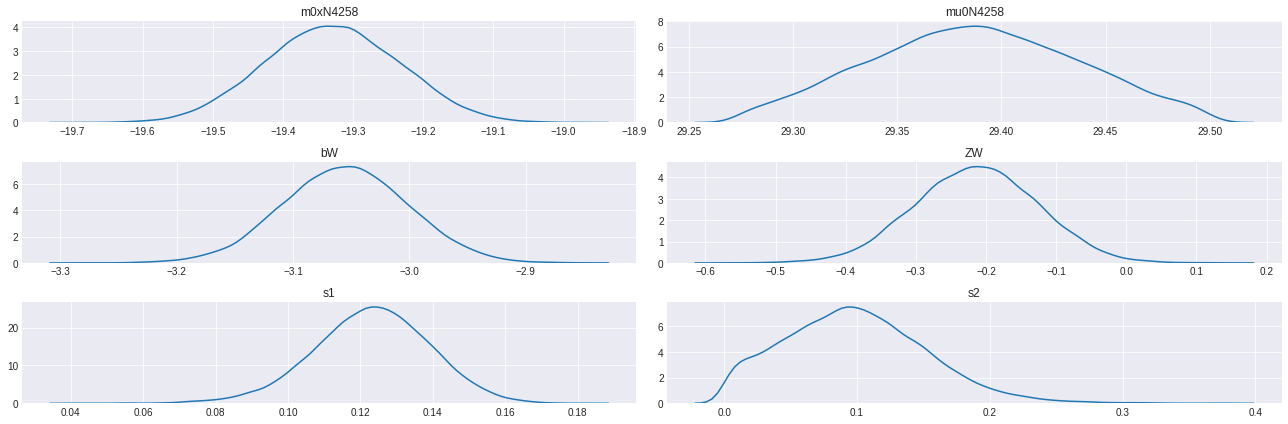

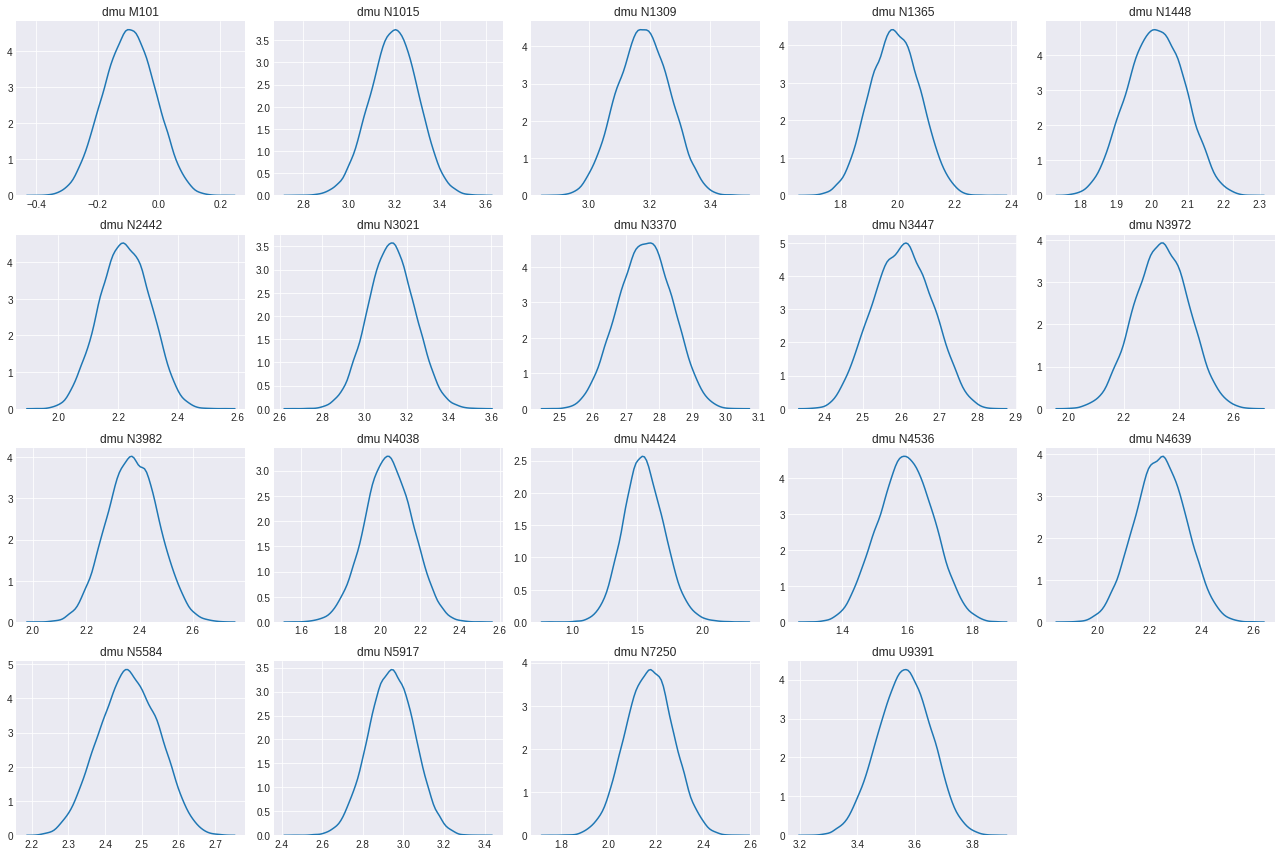

In [38]:
samples_data3 = fit3.extract()
fig, ax = plt.subplots(3, 2, figsize=(18,6))
names_list = ['m0xN4258', 'mu0N4258', 'bW', 'ZW', 's1', 's2']
for i, name in enumerate(names_list):
    sns.distplot(samples_data3[name], hist=False, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(name)
plt.tight_layout();
fig, ax = plt.subplots(4, 5, figsize=(18,12))
for i in range(19):
    sns.distplot(samples_data3['dmu'][:,i], hist=False, ax=ax[i//5, i%5])
    ax[i//5, i%5].set_title('dmu ' + gal_names[i])
ax[-1,-1].axis('off');
plt.tight_layout();

In [39]:
samples3 = fit3.extract()
M0xN4258 = np.percentile(samples3['m0xN4258'], 50)
M0xN4258

-19.33044677375939

In [40]:
10**((M0xN4258 + 5*ab + 25)/5)

70.24908069002436

In [41]:
ab_dist = np.random.normal(0.71273, 0.00176, len(samples3['m0xN4258']))
H0_dist = 10**((samples3['m0xN4258'] + 5*ab_dist + 25)/5)

3.1065281854748736

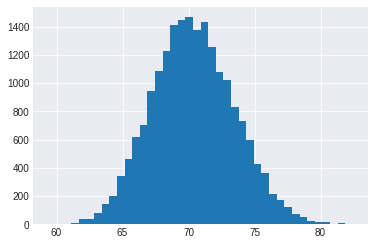

In [42]:
plt.hist(H0_dist, bins=40);
np.std(H0_dist)

In [43]:
ab = 0.71273
h0 = 72.25
exp_IA_mag = -19